# Jet tagging with neural networks

## Learning objectives

* Understand what jet tagging is and how to frame it as a machine learning task
* Understand the main steps needed to train and evaluate a jet tagger
* Learn how to download and process data with the 🤗 Datasets library
* Gain an introduction to the fastai library and how to push models to the Hugging Face Hub

## References

* Chapter 1 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) by G. Kasieczka et al.
* [_How Much Information is in a Jet?_](https://arxiv.org/abs/1704.08249) by K. Datta and A. Larkowski.

## The task and data

For the first few lectures, we'll be analysing the [_Top Quark Tagging_ dataset](https://huggingface.co/datasets/dl4phys/top_tagging), which is a famous benchmark that's used to compare the performance of jet classification algorithms. The dataset consists of around 2 million Monte Carlo simulated events in proton-proton collisions that have been clustered into jets.

Framed as a supervised machine learning task, the goal is to train a model that can classify each jet as either a top-quark signal or quark-gluon background.

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
# %pip install fastai==2.6.0 datasets git+https://github.com/huggingface/huggingface_hub

  Cloning https://github.com/huggingface/huggingface_hub to /tmp/pip-req-build-s5vn74la
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/huggingface_hub /tmp/pip-req-build-s5vn74la
  Resolved https://github.com/huggingface/huggingface_hub to commit c3b2c0301c854b1f1c42beaef9efdf6bee905f70
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of 

In [ ]:
# Check we have the correct fastai version
import fastai

assert fastai.__version__ == "2.6.0"

## Import libraries

In [ ]:
from datasets import load_dataset
from fastai.tabular.all import *
from huggingface_hub import from_pretrained_fastai, notebook_login, push_to_hub_fastai
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [ ]:
import datasets

# Suppress logs
datasets.logging.set_verbosity_error()

## Getting the data

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download and process the datasets that we'll encounter in this course. 🤗 Datasets provides smart caching and allows you to process larger-than-RAM datasets by exploiting a technique called _memory-mapping_ that provides a mapping between RAM and filesystem storage.

To download the Top Quark Tagging dataset from the [Hugging Face Hub](https://huggingface.co/datasets/dl4phys/top_tagging), we can use the `load_dataset()` function:

In [ ]:
top_tagging_ds = load_dataset("dl4phys/top_tagging")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

If we look inside our `top_tagging_ds` object

In [ ]:
top_tagging_ds

DatasetDict({
    train: Dataset({
        features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28'

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [ ]:
top_tagging_ds["train"]

Dataset({
    features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28', 'PX_28', 'PY_28', 'PZ_28', 

The `Dataset` object is one of the core data structures in 🤗 Datasets and behaves like an ordinary Python `list`, so we can query its length:

In [ ]:
len(top_tagging_ds["train"])

1211000

or access a single element by its index:

In [ ]:
top_tagging_ds["train"][0]

{'E_0': 474.0711364746094,
 'PX_0': -250.34703063964844,
 'PY_0': -223.65196228027344,
 'PZ_0': -334.73809814453125,
 'E_1': 103.23623657226562,
 'PX_1': -48.8662223815918,
 'PY_1': -56.790775299072266,
 'PZ_1': -71.0254898071289,
 'E_2': 105.25556945800781,
 'PX_2': -55.415000915527344,
 'PY_2': -49.96888732910156,
 'PZ_2': -74.23626708984375,
 'E_3': 40.17677688598633,
 'PX_3': -21.760696411132812,
 'PY_3': -18.71761131286621,
 'PZ_3': -28.112215042114258,
 'E_4': 22.4285831451416,
 'PX_4': -11.835756301879883,
 'PY_4': -10.374107360839844,
 'PZ_4': -15.979177474975586,
 'E_5': 20.334388732910156,
 'PX_5': -10.950518608093262,
 'PY_5': -9.545439720153809,
 'PZ_5': -14.228776931762695,
 'E_6': 19.030899047851562,
 'PX_6': -10.243264198303223,
 'PY_6': -9.004837036132812,
 'PZ_6': -13.272662162780762,
 'E_7': 13.460596084594727,
 'PX_7': -7.3433637619018555,
 'PY_7': -6.359743595123291,
 'PZ_7': -9.317526817321777,
 'E_8': 11.226107597351074,
 'PX_8': -5.981515884399414,
 'PY_8': -5.45

Here we see that a single row is repesented as a dictionary where the keys correspond to the column names. Since we won't need the top-quark 4-vector columns, let's remove them along with the `ttv` one:

In [ ]:
top_tagging_ds = top_tagging_ds.remove_columns(
    ["truthE", "truthPX", "truthPY", "truthPZ", "ttv"]
)

Although 🤗 Datasets provides a lot of low-level functionality for preprocessing datasets, it is often conventient to convert a `Dataset` object to a Pandas `DataFrame`. To enable the conversion, 🤗 Datasets provides a `set_format()` method that allows us to change the output format of the dataset:

In [ ]:
# Convert output format to DataFrames
top_tagging_ds.set_format("pandas")
# Create DataFrames for the training and test splits
train_df, test_df = top_tagging_ds["train"][:], top_tagging_ds["test"][:]
# Peek at first few rows
train_df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,PZ_197,E_198,PX_198,PY_198,PZ_198,E_199,PX_199,PY_199,PZ_199,is_signal_new
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


As we can see, each row consists of 4-vectors $(E_i, p_{x_i}, p_{y_i}, p_{z_i})$ that correspond to the maximum 200 particles that make up each jet. We can also see that each jet has been padded with zeros, since most won't have 200 particles. We also have an `is_signal_new` column that indicates whether the jet is a top quark signal (1) or QCD background (0).

Now that we've had a look at a sample of the raw data, let's take a look at how we can convert it to a format that is suitable for neural networks!

## Introducing fastai

To train our model, we'll use the [fastai library](https://github.com/fastai/fastai). fastai is the most popular framework for training deep neural networks with PyTorch and provides various application-specific classes for different types of deep learning data structures and architectures. It is also designed with a _layered API_, which means:

* We can use high-level components to quickly and easily get state-of-the-art results in standard deep learning domains
* Low-level components can be mixed and matched to build new approaches

In particular, this approach will allow us in later lessons to use pure PyTorch code to define our models, and then let fastai take care of the training loop (which is often an error-prone process).

**Basics of the API**

The most common steps one takes when training a model in fastai are:

* Create `DataLoaders` to feed batches of data to the model
* Create a `Learner` which wraps the architecture, optimizer, and data, and automatically chooses an appropriate loss function where possible
* Find a good learning rate
* Train your model
* Evaluate your model

Let's go through each of these steps to build a neural network that can classify top quark jets from the QCD background!

### From data to DataLoaders

To wrangle our data in a format that's suitable for training neural nets, we need to create an object called `DataLoaders`. To turn our dataset into a `DataLoaders` object we need to specify:

* What type of data we are dealing with (tabular, images, etc)
* How to get the examples
* How to label each example
* How to create the validation set

fastai provides a number of classes for different kinds of deep learning datasets and problems. In our case, the data is in a _tabular_ format (i.e. a table of rows and columns), so we can use the `TabularDataLoaders` class:

In [ ]:
# Downsample to ~0.5 if you're running on Colab / Kaggle which have limited RAM
frac_of_samples = 1.0
train_df = train_df.sample(int(frac_of_samples * len(train_df)), random_state=42)

features = list(train_df.drop(columns=["is_signal_new"]).columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="is_signal_new",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

Let's unpack this code a bit. The first thing we've specified is which columns of our dataset correspond to _continuous features_ via the `cont_names` argument. To do this, we've simply grabbed all column names from our `DataFrame`, except for the label column `is_signal_new`. Next, we've specified which column is the target in `y_names` and that this is a _categorical feature_ with `CategoryBlock`. Finally we've specified the training and validation splits with `RandomSplitter` and picked a batch size of 1,024 examples.

After we've defined a `DataLoaders` object, we can take a look at the data by using the `show_batch()` method:

In [ ]:
dls.show_batch()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,PY_2,PZ_2,E_3,PX_3,PY_3,PZ_3,E_4,PX_4,PY_4,PZ_4,E_5,PX_5,PY_5,PZ_5,E_6,PX_6,PY_6,PZ_6,E_7,PX_7,PY_7,PZ_7,E_8,PX_8,PY_8,PZ_8,E_9,PX_9,PY_9,PZ_9,E_10,PX_10,PY_10,PZ_10,E_11,PX_11,PY_11,PZ_11,E_12,PX_12,PY_12,PZ_12,E_13,PX_13,PY_13,PZ_13,E_14,PX_14,PY_14,PZ_14,E_15,PX_15,PY_15,PZ_15,E_16,PX_16,PY_16,PZ_16,E_17,PX_17,PY_17,PZ_17,E_18,PX_18,PY_18,PZ_18,E_19,PX_19,PY_19,PZ_19,E_20,PX_20,PY_20,PZ_20,E_21,PX_21,PY_21,PZ_21,E_22,PX_22,PY_22,PZ_22,E_23,PX_23,PY_23,PZ_23,E_24,PX_24,PY_24,PZ_24,E_25,PX_25,PY_25,PZ_25,E_26,PX_26,PY_26,PZ_26,E_27,PX_27,PY_27,PZ_27,E_28,PX_28,PY_28,PZ_28,E_29,PX_29,PY_29,PZ_29,E_30,PX_30,PY_30,PZ_30,E_31,PX_31,PY_31,PZ_31,E_32,PX_32,PY_32,PZ_32,E_33,PX_33,PY_33,PZ_33,E_34,PX_34,PY_34,PZ_34,E_35,PX_35,PY_35,PZ_35,E_36,PX_36,PY_36,PZ_36,E_37,PX_37,PY_37,PZ_37,E_38,PX_38,PY_38,PZ_38,E_39,PX_39,PY_39,PZ_39,E_40,PX_40,PY_40,PZ_40,E_41,PX_41,PY_41,PZ_41,E_42,PX_42,PY_42,PZ_42,E_43,PX_43,PY_43,PZ_43,E_44,PX_44,PY_44,PZ_44,E_45,PX_45,PY_45,PZ_45,E_46,PX_46,PY_46,PZ_46,E_47,PX_47,PY_47,PZ_47,E_48,PX_48,PY_48,PZ_48,E_49,PX_49,PY_49,PZ_49,E_50,PX_50,PY_50,PZ_50,E_51,PX_51,PY_51,PZ_51,E_52,PX_52,PY_52,PZ_52,E_53,PX_53,PY_53,PZ_53,E_54,PX_54,PY_54,PZ_54,E_55,PX_55,PY_55,PZ_55,E_56,PX_56,PY_56,PZ_56,E_57,PX_57,PY_57,PZ_57,E_58,PX_58,PY_58,PZ_58,E_59,PX_59,PY_59,PZ_59,E_60,PX_60,PY_60,PZ_60,E_61,PX_61,PY_61,PZ_61,E_62,PX_62,PY_62,PZ_62,E_63,PX_63,PY_63,PZ_63,E_64,PX_64,PY_64,PZ_64,E_65,PX_65,PY_65,PZ_65,E_66,PX_66,PY_66,PZ_66,E_67,PX_67,PY_67,PZ_67,E_68,PX_68,PY_68,PZ_68,E_69,PX_69,PY_69,PZ_69,E_70,PX_70,PY_70,PZ_70,E_71,PX_71,PY_71,PZ_71,E_72,PX_72,PY_72,PZ_72,E_73,PX_73,PY_73,PZ_73,E_74,PX_74,PY_74,PZ_74,E_75,PX_75,PY_75,PZ_75,E_76,PX_76,PY_76,PZ_76,E_77,PX_77,PY_77,PZ_77,E_78,PX_78,PY_78,PZ_78,E_79,PX_79,PY_79,PZ_79,E_80,PX_80,PY_80,PZ_80,E_81,PX_81,PY_81,PZ_81,E_82,PX_82,PY_82,PZ_82,E_83,PX_83,PY_83,PZ_83,E_84,PX_84,PY_84,PZ_84,E_85,PX_85,PY_85,PZ_85,E_86,PX_86,PY_86,PZ_86,E_87,PX_87,PY_87,PZ_87,E_88,PX_88,PY_88,PZ_88,E_89,PX_89,PY_89,PZ_89,E_90,PX_90,PY_90,PZ_90,E_91,PX_91,PY_91,PZ_91,E_92,PX_92,PY_92,PZ_92,E_93,PX_93,PY_93,PZ_93,E_94,PX_94,PY_94,PZ_94,E_95,PX_95,PY_95,PZ_95,E_96,PX_96,PY_96,PZ_96,E_97,PX_97,PY_97,PZ_97,E_98,PX_98,PY_98,PZ_98,E_99,PX_99,PY_99,PZ_99,E_100,PX_100,PY_100,PZ_100,E_101,PX_101,PY_101,PZ_101,E_102,PX_102,PY_102,PZ_102,E_103,PX_103,PY_103,PZ_103,E_104,PX_104,PY_104,PZ_104,E_105,PX_105,PY_105,PZ_105,E_106,PX_106,PY_106,PZ_106,E_107,PX_107,PY_107,PZ_107,E_108,PX_108,PY_108,PZ_108,E_109,PX_109,PY_109,PZ_109,E_110,PX_110,PY_110,PZ_110,E_111,PX_111,PY_111,PZ_111,E_112,PX_112,PY_112,PZ_112,E_113,PX_113,PY_113,PZ_113,E_114,PX_114,PY_114,PZ_114,E_115,PX_115,PY_115,PZ_115,E_116,PX_116,PY_116,PZ_116,E_117,PX_117,PY_117,PZ_117,E_118,PX_118,PY_118,PZ_118,E_119,PX_119,PY_119,PZ_119,E_120,PX_120,PY_120,PZ_120,E_121,PX_121,PY_121,PZ_121,E_122,PX_122,PY_122,PZ_122,E_123,PX_123,PY_123,PZ_123,E_124,PX_124,PY_124,PZ_124,E_125,PX_125,PY_125,PZ_125,E_126,PX_126,PY_126,PZ_126,E_127,PX_127,PY_127,PZ_127,E_128,PX_128,PY_128,PZ_128,E_129,PX_129,PY_129,PZ_129,E_130,PX_130,PY_130,PZ_130,E_131,PX_131,PY_131,PZ_131,E_132,PX_132,PY_132,PZ_132,E_133,PX_133,PY_133,PZ_133,E_134,PX_134,PY_134,PZ_134,E_135,PX_135,PY_135,PZ_135,E_136,PX_136,PY_136,PZ_136,E_137,PX_137,PY_137,PZ_137,E_138,PX_138,PY_138,PZ_138,E_139,PX_139,PY_139,PZ_139,E_140,PX_140,PY_140,PZ_140,E_141,PX_141,PY_141,PZ_141,E_142,PX_142,PY_142,PZ_142,E_143,PX_143,PY_143,PZ_143,E_144,PX_144,PY_144,PZ_144,E_145,PX_145,PY_145,PZ_145,E_146,PX_146,PY_146,PZ_146,E_147,PX_147,PY_147,PZ_147,E_148,PX_148,PY_148,PZ_148,E_149,PX_149,PY_149,PZ_149,E_150,PX_150,PY_150,PZ_150,E_151,PX_151,PY_151,PZ_151,E_152,PX_152,PY_152,PZ_152,E_153,PX_153,PY_153,PZ_153,E_154,PX_154,PY_154,PZ_154,E_155,PX_155,PY_155,PZ_155,E_156,PX_156,PY_156,PZ_156,E_157,PX_157,PY_157,PZ_157,E_158,PX_158,PY_158,PZ_158,E_159,PX_159,PY_159,PZ_159,E_160,PX_160,PY_160,PZ_160,E_161,PX_161,PY_161,PZ_161,E_162,PX_162,PY_162,PZ_162,E_163,PX_163,PY_163,PZ_163,E_164,PX_16

This looks like the format we want: we have a matrix of numerical features encoded in the 4-vectors, along with a target denoted by the `is_signal_new` column.

### Create a Learner

We can now create the `Learner` for this data. fastai provides various application-specific learner classes, each of which come with a set of good defaults for training. In our case, we'll use the `tabular_learner` class:

In [ ]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

NameError: ignored

By default, `tabular_learner` creates a neural network with two hidden layers and 200 and 100 activations each. This works great for small datasets, but since our dataset is quite large, we've increased the depth of the network by adding two more layers. This also matches the architecture chosen in Section 3.2.2 of [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) review that we'll compare to later.

We've also provided two common classification metrics to track during training: accuracy and the Area Under the ROC Curve (ROC AUC). We'll look at ROC AUC in more detail later, so for now let's take a look at our network with the `summary()` method:

In [ ]:
learn.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     1024 x 50           
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               1

Here we can see that this particular network has around 215,000 parameters - although this sounds like a lot, it's actually a very small model by modern standards (e.g. in natural language processing, some models have hundreds of billions of parameters!).

### Find a good learning rate

The learning rate is one of the most important hyperparameters involved in training neural networks, so it's important to make sure you've picked a good one. We'll see in the next lesson exactly how this parameter impacts training, but for now it is enough to know that:

* If our learning rate is too low, it will take a long time to train the model and there is a good chance of overfitting.
* If our learning rate is too high, the training process can diverge.

To handle these two extremes, fastai provides a _learning rate finder_ that tracks the loss as we increase the learning rate. You can see this in action by using the `lr_find()` method of any `Learner`:

SuggestedLRs(valley=0.0006918309954926372)

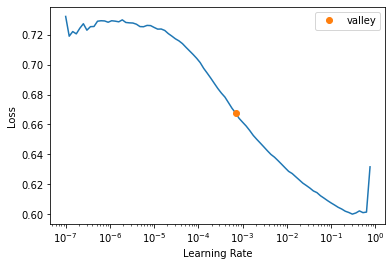

In [ ]:
learn.lr_find()

From this curve we can see that the loss hits a minimum around a learning rate of $3 \times 10^{-1}$, so we should select a learning rate lower than this point. The `lr_find()` method provides a handy heuristic to pick the learning rate 1-2 orders of magnitude less than the minimum, as indicated by the orange dot.

### Train your model

In the above learning rate plot, it appears a learning rate of around $10^{-3}$ would be good, so let's choose that and train our models for 3 epochs:

In [ ]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.512565,0.511615,0.732775,0.809289,00:20
1,0.419058,0.404574,0.810632,0.891700,00:20
2,0.381482,0.372323,0.830776,0.907655,00:20


Once the model is trained, we can view the results in various ways. A simple approach is to use the `show_results()` method to compare the model errors:

In [ ]:
learn.show_results()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,PY_2,PZ_2,E_3,PX_3,PY_3,PZ_3,E_4,PX_4,PY_4,PZ_4,E_5,PX_5,PY_5,PZ_5,E_6,PX_6,PY_6,PZ_6,E_7,PX_7,PY_7,PZ_7,E_8,PX_8,PY_8,PZ_8,E_9,PX_9,PY_9,PZ_9,E_10,PX_10,PY_10,PZ_10,E_11,PX_11,PY_11,PZ_11,E_12,PX_12,PY_12,PZ_12,E_13,PX_13,PY_13,PZ_13,E_14,PX_14,PY_14,PZ_14,E_15,PX_15,PY_15,PZ_15,E_16,PX_16,PY_16,PZ_16,E_17,PX_17,PY_17,PZ_17,E_18,PX_18,PY_18,PZ_18,E_19,PX_19,PY_19,PZ_19,E_20,PX_20,PY_20,PZ_20,E_21,PX_21,PY_21,PZ_21,E_22,PX_22,PY_22,PZ_22,E_23,PX_23,PY_23,PZ_23,E_24,PX_24,PY_24,PZ_24,E_25,PX_25,PY_25,PZ_25,E_26,PX_26,PY_26,PZ_26,E_27,PX_27,PY_27,PZ_27,E_28,PX_28,PY_28,PZ_28,E_29,PX_29,PY_29,PZ_29,E_30,PX_30,PY_30,PZ_30,E_31,PX_31,PY_31,PZ_31,E_32,PX_32,PY_32,PZ_32,E_33,PX_33,PY_33,PZ_33,E_34,PX_34,PY_34,PZ_34,E_35,PX_35,PY_35,PZ_35,E_36,PX_36,PY_36,PZ_36,E_37,PX_37,PY_37,PZ_37,E_38,PX_38,PY_38,PZ_38,E_39,PX_39,PY_39,PZ_39,E_40,PX_40,PY_40,PZ_40,E_41,PX_41,PY_41,PZ_41,E_42,PX_42,PY_42,PZ_42,E_43,PX_43,PY_43,PZ_43,E_44,PX_44,PY_44,PZ_44,E_45,PX_45,PY_45,PZ_45,E_46,PX_46,PY_46,PZ_46,E_47,PX_47,PY_47,PZ_47,E_48,PX_48,PY_48,PZ_48,E_49,PX_49,PY_49,PZ_49,E_50,PX_50,PY_50,PZ_50,E_51,PX_51,PY_51,PZ_51,E_52,PX_52,PY_52,PZ_52,E_53,PX_53,PY_53,PZ_53,E_54,PX_54,PY_54,PZ_54,E_55,PX_55,PY_55,PZ_55,E_56,PX_56,PY_56,PZ_56,E_57,PX_57,PY_57,PZ_57,E_58,PX_58,PY_58,PZ_58,E_59,PX_59,PY_59,PZ_59,E_60,PX_60,PY_60,PZ_60,E_61,PX_61,PY_61,PZ_61,E_62,PX_62,PY_62,PZ_62,E_63,PX_63,PY_63,PZ_63,E_64,PX_64,PY_64,PZ_64,E_65,PX_65,PY_65,PZ_65,E_66,PX_66,PY_66,PZ_66,E_67,PX_67,PY_67,PZ_67,E_68,PX_68,PY_68,PZ_68,E_69,PX_69,PY_69,PZ_69,E_70,PX_70,PY_70,PZ_70,E_71,PX_71,PY_71,PZ_71,E_72,PX_72,PY_72,PZ_72,E_73,PX_73,PY_73,PZ_73,E_74,PX_74,PY_74,PZ_74,E_75,PX_75,PY_75,PZ_75,E_76,PX_76,PY_76,PZ_76,E_77,PX_77,PY_77,PZ_77,E_78,PX_78,PY_78,PZ_78,E_79,PX_79,PY_79,PZ_79,E_80,PX_80,PY_80,PZ_80,E_81,PX_81,PY_81,PZ_81,E_82,PX_82,PY_82,PZ_82,E_83,PX_83,PY_83,PZ_83,E_84,PX_84,PY_84,PZ_84,E_85,PX_85,PY_85,PZ_85,E_86,PX_86,PY_86,PZ_86,E_87,PX_87,PY_87,PZ_87,E_88,PX_88,PY_88,PZ_88,E_89,PX_89,PY_89,PZ_89,E_90,PX_90,PY_90,PZ_90,E_91,PX_91,PY_91,PZ_91,E_92,PX_92,PY_92,PZ_92,E_93,PX_93,PY_93,PZ_93,E_94,PX_94,PY_94,PZ_94,E_95,PX_95,PY_95,PZ_95,E_96,PX_96,PY_96,PZ_96,E_97,PX_97,PY_97,PZ_97,E_98,PX_98,PY_98,PZ_98,E_99,PX_99,PY_99,PZ_99,E_100,PX_100,PY_100,PZ_100,E_101,PX_101,PY_101,PZ_101,E_102,PX_102,PY_102,PZ_102,E_103,PX_103,PY_103,PZ_103,E_104,PX_104,PY_104,PZ_104,E_105,PX_105,PY_105,PZ_105,E_106,PX_106,PY_106,PZ_106,E_107,PX_107,PY_107,PZ_107,E_108,PX_108,PY_108,PZ_108,E_109,PX_109,PY_109,PZ_109,E_110,PX_110,PY_110,PZ_110,E_111,PX_111,PY_111,PZ_111,E_112,PX_112,PY_112,PZ_112,E_113,PX_113,PY_113,PZ_113,E_114,PX_114,PY_114,PZ_114,E_115,PX_115,PY_115,PZ_115,E_116,PX_116,PY_116,PZ_116,E_117,PX_117,PY_117,PZ_117,E_118,PX_118,PY_118,PZ_118,E_119,PX_119,PY_119,PZ_119,E_120,PX_120,PY_120,PZ_120,E_121,PX_121,PY_121,PZ_121,E_122,PX_122,PY_122,PZ_122,E_123,PX_123,PY_123,PZ_123,E_124,PX_124,PY_124,PZ_124,E_125,PX_125,PY_125,PZ_125,E_126,PX_126,PY_126,PZ_126,E_127,PX_127,PY_127,PZ_127,E_128,PX_128,PY_128,PZ_128,E_129,PX_129,PY_129,PZ_129,E_130,PX_130,PY_130,PZ_130,E_131,PX_131,PY_131,PZ_131,E_132,PX_132,PY_132,PZ_132,E_133,PX_133,PY_133,PZ_133,E_134,PX_134,PY_134,PZ_134,E_135,PX_135,PY_135,PZ_135,E_136,PX_136,PY_136,PZ_136,E_137,PX_137,PY_137,PZ_137,E_138,PX_138,PY_138,PZ_138,E_139,PX_139,PY_139,PZ_139,E_140,PX_140,PY_140,PZ_140,E_141,PX_141,PY_141,PZ_141,E_142,PX_142,PY_142,PZ_142,E_143,PX_143,PY_143,PZ_143,E_144,PX_144,PY_144,PZ_144,E_145,PX_145,PY_145,PZ_145,E_146,PX_146,PY_146,PZ_146,E_147,PX_147,PY_147,PZ_147,E_148,PX_148,PY_148,PZ_148,E_149,PX_149,PY_149,PZ_149,E_150,PX_150,PY_150,PZ_150,E_151,PX_151,PY_151,PZ_151,E_152,PX_152,PY_152,PZ_152,E_153,PX_153,PY_153,PZ_153,E_154,PX_154,PY_154,PZ_154,E_155,PX_155,PY_155,PZ_155,E_156,PX_156,PY_156,PZ_156,E_157,PX_157,PY_157,PZ_157,E_158,PX_158,PY_158,PZ_158,E_159,PX_159,PY_159,PZ_159,E_160,PX_160,PY_160,PZ_160,E_161,PX_161,PY_161,PZ_161,E_162,PX_162,PY_162,PZ_162,E_163,PX_163,PY_163,PZ_163,E_164,PX_16

Here we can see that model made a handful of errors, which is expected since our accuracy is only around 82%. However, evaluating our model’s predictions on the same data it was trained on is almost always a recipe for disaster! Why? The problem is that the model may memorise the structure of the data it sees and fail to provide good predictions when shown new data. Let's see how we can evaluate our model on examples from the _test set_ that it has never seen.

### Evaluate your model

The learners in fastai are equipped with `predict()` and `get_preds()` methods that allow one to evaluae the model on new data. To use them, we'll need a new `DataLoader` which we can create by simply passing in a `DataFrame` of the test events:

In [ ]:
test_dl = learn.dls.test_dl(test_items=test_df)

Now that we have a `DataLoader`, it's a simple matter to compute the predictions with the `get_preds()` method:

In [ ]:
preds, targs = learn.get_preds(dl=test_dl)

Let's take a look at the first few values of `preds` and `targs`:

In [ ]:
preds[:5], targs[:5]

(tensor([[0.9980, 0.0020],
         [0.6680, 0.3320],
         [0.8597, 0.1403],
         [0.4682, 0.5318],
         [0.9532, 0.0468]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]], dtype=torch.int8))

Here we can see that they are _tensors_. In PyTorch, a tensor is similar to the arrays that you may be familiar with in Numpy. Tensors have a rank that can be inspected by using the `size()` method:

In [ ]:
preds.size(), targs.size()

(torch.Size([404000, 2]), torch.Size([404000, 1]))

In this case, we see that `preds` is a rank-2 tensor (i.e. a matrix), while `targs` is rank-1 (a vector). Note that each dimension in `preds` corresponds to the _probabilities_ of the model for the two classes (signal vs background). We can visualise the distribution of the probabilities for each class by filtering the `preds` tensor according to the ground truch labels and then plotting the result as a histogram:

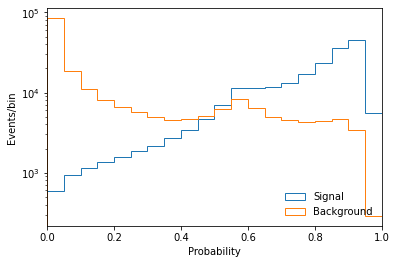

In [ ]:
signal_test = preds[:, 1][targs.flatten() == 1].numpy()
background_test = preds[:, 1][targs.flatten() == 0].numpy()

plt.hist(signal_test, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

We see that although the model assigns high (low) probabilities to the signal (background) events, a fair amount of the signal events overlap with background ones.  To handle this, one usually defines a "cut" or threshold that only includes events above that value. For example, if define the cut at 0, then all the events are counted and the signal efficiency $\epsilon_S$ and background efficiency $\epsilon_B$ are both 1. As we increase the cut, we reject more and more background events and the result is a curve with $\epsilon_{B,S}$ ranging from 0 to 1.

This curve is equivalent to the Reciever Operating Characteristic (ROC) curve which plots the true positive rate

$$ \mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} \,, \qquad \mathrm{TP\, (FP)} = \mathrm{number\, of\, true\, (false) \,positives}\,, $$

against the false positive rate FPR, where the FPR is the ratio of negative instances that are incorrectly classified as positive. In general there is a tradeoff between these two quantities: the higher the TPR, the more false positives (FPR) the classifier produces.

To visualise the ROC curve for our model's predictions, we can use the handy `roc_curve()` function from scikit-learn:

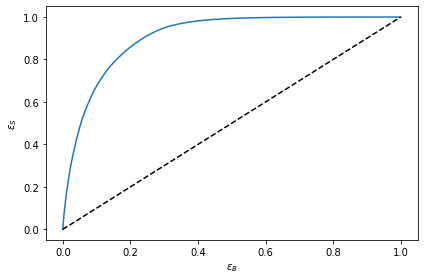

In [ ]:
# fpr = epsilon_B, tpr = epsilon_S
fpr, tpr, thresholds = roc_curve(y_true=targs, y_score=preds[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

A perfect classifier would have a ROC curve with all signal and background events correctly identified, i.e. an Area Under the Curve (AUC) of 1. Let's compute this area along with the accuracy on the test set:

In [ ]:
acc_test = accuracy_score(targs, preds.argmax(dim=-1))
auc_test = auc(fpr, tpr)
print(f"Accuracy: {acc_test:.4f}")
print(f"AUC: {auc_test:.4f}")

Accuracy: 0.8314
AUC: 0.9077


Since the AUC is dominated by values at large $\epsilon_B$, it is common to also report the background rejection at a fixed signal efficiency (often 30%). We can do that by defining an interpolating function across the `tpr` and `fpr` values as follows:

In [ ]:
background_eff = interp1d(tpr, fpr)
background_eff_at_30 = background_eff(0.3)
print(f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}")

Backround rejection at signal efficiency 0.3: 42.233


Comparing these results again the [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) review, shows that our baseline model falls short of the models in the review, which get a typical accuracy of 93% and an AUC of 98%.

Let's see if we can train a better model by choosing a clever representation of the input data! Before doing that, let's collect this evaluation logic in a function that we can reuse later:

In [ ]:
def compute_metrics(learn, test_df):
    test_dl = learn.dls.test_dl(test_items=test_df)
    preds, targs = learn.get_preds(dl=test_dl)
    fpr, tpr, _ = roc_curve(y_true=targs, y_score=preds[:, 1])
    acc_test = accuracy_score(targs, preds.argmax(dim=-1))
    auc_test = auc(fpr, tpr)
    background_eff = interp1d(tpr, fpr)
    background_eff_at_30 = background_eff(0.3)

    print(f"Accuracy: {acc_test:.4f}")
    print(f"AUC: {auc_test:.4f}")
    print(
        f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}"
    )
    return fpr, tpr

In [ ]:
fpr_baseline, tpr_baseline = compute_metrics(learn, test_df)

Accuracy: 0.8314
AUC: 0.9077
Backround rejection at signal efficiency 0.3: 42.233


## Jet representations

In any machine learning problem, how we represent the data often has a large impact on the performance of the models we train. For jet tagging, the most common approaches one finds in the literature include:

* **Jets as images.** A jet image is a pixelated grayscale image, where the pixel intensity represents the energy (or transverse momentum) of all particles that deposited energy in a particular location in the $\eta-\phi$ plane. Typically, _convolutional neural networks (CNNs)_ are used to process the images and we'll ecplore these architectures in a future lesson.
* **Jets as sequences.** Here the idea is to order the particles in a jet (usually by $p_T$) and use sequence-based architectures like _recurrent neural networks (RNNs)._
* **Jets as graphs.** This approach treats each jet as a generic graph of nodes and edges. Graph neural networks (which we'll also encounter later in the course) excel on this tpe of data.
* **Jets as sets.** A generalisation of the previous representations, this approach simply treats each jets as an unordered collection or point cloud of 4-vectors.
* **Theory-inspired representations.** Instead of representing the jets in formats to match specific neural network architectures, these approaches use results on IR safety from QCD to represent the jets as a simplified set of features. Fully-connected neural networks are then trained on these features.

You can find more details about each representation in a nice [review article](https://arxiv.org/abs/1709.04464) from 2017.

In this lesson and the next, we'll use one of the theory-inspired representations called $N$-subjettiness. Let's take a look.

### Representing jets with $N$-subjettiness observables

$N$-subjettiness observables quantify how much of the radiation in a jet is aligned along different subjet axes. Although originally used for analytic approaches to distinguish different decays and event topologies, these observable can also be used as inputs for machine learning models and provide strong discriminating power.

To be precise, an $N$-subjettiness observable $\tau_N^{(\beta)}$ measures the radiation about $N$ axes in the jet according to an angular exponent $\beta>0$:

$$ \tau_N^{(\beta)} = \frac{1}{p_{T,J}} \sum_{i\in J} p_{T,i} \min \left\{ R_{1,i}^\beta, R_{1,i}^\beta, \ldots , R_{1,i}^\beta \right\} $$

Here $p_{T,J}$ is the transverse momentum of the jet, $p_{T,i}$ is the transverse momentum of particle $i$ in the jet, and $R_{K,i}$ is the distance in the $\eta-\phi$ plane of particle $i$ to axis $K$.

To measure substructure in a jet, one thus needs to measure a suitable number of $N$-subjettiness observables. In practice this is done by specifying the corrdinates of $M$-body phase space in terms of $3M - 4$ $N$-subjettiness observables:

$$ \left\{ \tau_1^{(0.5)}, \tau_1^{(1)}, \tau_1^{(2)}, \tau_2^{(0.5)}, \tau_2^{(1)}, \tau_2^{(2)}, \ldots , \tau_{m-1}^{(0.5)}, \tau_{m-1}^{(1)}, \tau_{m-1}^{(2)} \right\} $$

To see how we can use this basis as features for a neural network, we have computed $N$-subjettiness observables up through 6-body phase space using the [pyjet library](https://github.com/scikit-hep/pyjet). You can download these features via the `load_dataset()` function as follows:

In [ ]:
nsubjet_ds = load_dataset("dl4phys/top_tagging_nsubjettiness")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/lewis/.cache/huggingface/datasets/parquet/dl4phys--top_tagging_nsubjettiness-d7eca4f13187c4c4/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

As before, we'll convert our `Dataset` object to a pandas `DataFrame`:

In [ ]:
nsubjet_ds.set_format("pandas")
train_df, test_df = nsubjet_ds["train"][:], nsubjet_ds["test"][:]
train_df.head()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,543.633944,25.846792,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,...,0.024336,0.001115,0.000008,0.004252,0.000234,7.706005e-07,0.000000,0.000000,0.000000e+00,0
1,452.411860,13.388679,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,...,0.056854,0.005454,0.000072,0.044211,0.004430,6.175314e-05,0.037458,0.003396,3.670517e-05,0
2,429.495258,32.021091,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,...,0.078205,0.012678,0.000567,0.052374,0.005935,9.395772e-05,0.037572,0.002932,2.237277e-05,0
3,512.675443,6.684734,0.102580,0.011369,0.000170,0.086306,0.007760,0.000071,0.068169,0.005386,...,0.044705,0.002376,0.000008,0.027895,0.001364,4.400042e-06,0.009012,0.000379,6.731099e-07,0
4,527.956859,133.985415,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,...,0.143768,0.033249,0.003689,0.135407,0.029054,2.593460e-03,0.110805,0.023179,2.202088e-03,0


Following Section 3.2.2 of [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) revie, we've also included the jet mass and jet $p_T$ as input variables to allow the network to learn physical scales.

Let's now train a model using these features. As before, we need to first define our `DataLoaders` object:

In [ ]:
features = list(train_df.drop(columns=["label"]).columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="label",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

And just like before it's a good idea to sanity check your data is formatted correctly with the `show_batch()` method:

In [ ]:
dls.show_batch()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,461.643372,58.081078,0.267102,0.088350,0.015706,0.182025,0.042736,0.005997,0.141589,0.029279,0.003416,0.120514,0.020182,0.001241,0.087524,0.013450,8.641806e-04,0.071813,0.010891,7.935878e-04,0
1,513.609070,129.866760,0.431575,0.202836,0.063762,0.327400,0.133254,0.040518,0.130512,0.023113,0.001422,0.114296,0.017393,0.000718,0.095355,0.013060,4.953301e-04,0.082081,0.009201,2.063908e-04,1
2,538.835754,21.680426,0.198053,0.039486,0.001619,0.038596,0.003683,0.000069,0.027622,0.002028,0.000024,0.018646,0.000869,0.000002,0.008453,0.000373,9.324909e-07,0.000000,0.000000,0.000000e+00,0
3,569.943970,14.177874,0.124071,0.018201,0.000619,0.091646,0.008896,0.000096,0.039875,0.002515,0.000014,0.008931,0.000650,0.000005,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0
4,462.787750,167.859375,0.618895,0.366184,0.132532,0.274511,0.074367,0.006216,0.217250,0.049036,0.003042,0.185648,0.036743,0.001925,0.159761,0.027603,9.593506e-04,0.136480,0.022875,7.589663e-04,0
5,481.187836,21.275795,0.197569,0.041092,0.001955,0.117185,0.018937,0.000665,0.099367,0.012753,0.000281,0.085475,0.009725,0.000197,0.062330,0.005595,6.916394e-05,0.052907,0.004203,3.618403e-05,0
6,574.911987,42.508812,0.180569,0.037991,0.005424,0.108725,0.020727,0.004305,0.041011,0.003381,0.000071,0.028611,0.002046,0.000036,0.015887,0.001213,2.921311e-05,0.011662,0.000650,1.678485e-05,0
7,463.576508,53.591480,0.288984,0.092856,0.013347,0.224898,0.052918,0.003495,0.173352,0.032209,0.001432,0.133511,0.024035,0.001166,0.094518,0.015667,6.733207e-04,0.088208,0.012934,3.997425e-04,0
8,519.291260,17.618988,0.151518,0.026514,0.001151,0.085697,0.009568,0.000241,0.058985,0.004627,0.000063,0.039815,0.002514,0.000013,0.028490,0.001495,5.074164e-06,0.017248,0.000635,8.944363e-07,0
9,478.084625,124.346436,0.507225,0.254765,0.067330,0.182893,0.043455,0.006483,0.126383,0.019826,0.001121,0.089138,0.014123,0.000801,0.044779,0.005901,1.272047e-04,0.029706,0.003584,5.757449e-05,1


This looks good, so the last step is to create a `Learner` and find a good learning rate:

SuggestedLRs(valley=0.002511886414140463)

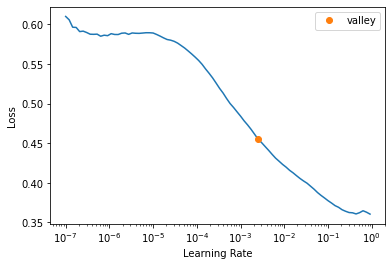

In [ ]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

learn.lr_find()

This curve is similar to what we found before so let's pick a learning rate of $10^{-3}$ and train for 3 epochs:

In [ ]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.234615,0.228308,0.903832,0.966693,00:08
1,0.225498,0.227929,0.903348,0.967744,00:08
2,0.222219,0.224911,0.904133,0.968275,00:08


We can already see that training on the $N$-subjettiness features has produced a better model than our baseline, which achieved around 83% and $91%$ accuracy and AUC score respectively. Let's wrap up by computing these metrics on the test set with our `compute_metrics()` function:

In [ ]:
test_df = nsubjet_ds["test"].to_pandas()
fpr_nsubjet, tpr_nsubjet = compute_metrics(learn, test_df)

Accuracy: 0.9037
AUC: 0.9677
Backround rejection at signal efficiency 0.3: 373.915


This is much better and now just a 1-2% the classifiers reported in the review paper! We can also compare both models by plotting the background rejection rate against the signal efficiency:

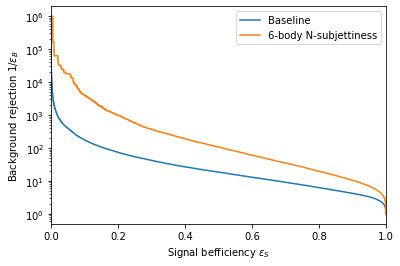

In [ ]:
fig, ax = plt.subplots()

plt.plot(tpr_baseline, 1 / (fpr_baseline + 1e-6), label="Baseline")
plt.plot(tpr_nsubjet, 1 / (fpr_nsubjet + 1e-6), label="6-body N-subjettiness")
plt.xlabel("Signal befficiency $\epsilon_{S}$")
plt.ylabel("Background rejection $1/\epsilon_{B}$")
plt.xlim(0, 1)
plt.yscale("log")
plt.legend()
plt.show()

## Saving and sharing the model

We've seen in this lecture how to load and prepare datasets for deep neural nets, and how to train the models with fastai. But what happens if you want to save your model for future use, or to simply reproduce the results from your paper in PRL 🙃?

One way to do this is by use the `save()` method of the `Learner`, which will store your model in a format called [pickle](https://docs.python.org/3/library/pickle.html). This is great if you're doing quick experimentation, but at some point you might want to share the model with a colleague or the wider research community.

In the same way we were able to download a dataset from the Hugging Face Hub, it is also possible to share fastai models on the platform! To do so, you'll first need to:

* Create a Hugging Face account (it's free): https://huggingface.co/join
* [Optional] Join the [Deep Learning for Particle Physicists](https://huggingface.co/dl4phys) organisation to share your models with the rest of the class.

Once you're created an account, you can log into the Hub with the following helper function:

In [ ]:
notebook_login()

This will display a widget in which you can enter a Hugging Face token - you can find details on how to create tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). Once you're logged in, pushing our model to the Hub is simple via the `push_to_hub_fastai()` function:

In [ ]:
user_or_org = "dl4phys"  # This can also be your Hub username, e.g. lewtun
model_id = "lewtun-top-tagging-nsubs"  # Change this to something different
repo_id = f"{user_or_org}/{model_id}"

push_to_hub_fastai(
    learner=learn,
    repo_id=repo_id,
    commit_message="Add new Learner",
)

This will push the model's weights to the Hub, as well as a `pyproject.toml` file that defines the environment in which the `Learner` was created. Now that we've pushed our model to the Hub, we can now download it on any machine where fastai is installed! This is really handy when you need to quickly reproduce the results from your paper, e.g. here is how we use the `from_pretrained_fastai()` function to download the model and re-compute our scores on the test set:

In [ ]:
learner = from_pretrained_fastai(repo_id)
_, _ = compute_metrics(learner, test_df)

Accuracy: 0.9037
AUC: 0.9677
Backround rejection at signal efficiency 0.3: 373.915


# Jet images and transfer learning with CNNs

## Learning objectives

* Understand how to convert jets into images
* Know what transfer learning is and it's advantages compared to training a neural network from scratch
* Understand the main steps needed to fine-tune a convolutional neural network

## References

* Chapter 1 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) by G. Kasieczka et al.
* [Jet-Images -- Deep Learning Edition](https://arxiv.org/abs/1511.05190) by L. de Oliviera et al.

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
%pip install fastai==2.6.0 datasets energyflow huggingface_hub

## Imports

In [ ]:
import pandas as pd
from datasets import load_dataset
from energyflow.utils import (
    center_ptyphims,
    phi_fix,
    pixelate,
    ptyphims_from_p4s,
    reflect_ptyphims,
    rotate_ptyphims,
)
from fastai.vision.all import *
from huggingface_hub import from_pretrained_fastai
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor
from scipy.interpolate import interp1d


In [ ]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

## Creating jet images

As we saw in lectures 1 and 2, there are various ways to represent jet data for neural networks. So far, we've focused on $N$-subjettiness features $\tau_N^{\beta}$, which represent jets in a _tabular_ format. Today, we'll examine another popular representation that treats _jets as 2D images_. An example from the top tagging review is shown below:

<center>
    <img alt="jet-images" caption="Jet images" src="https://github.com/lewtun/dl4phys/blob/main/images/jet-images.png?raw=1" id="jet-images" width=800/>
</center>

But why consider images in the first place? The motivation here is partly historical: computer vision is where the deep learning revolution started in 2011, with [DanNet](https://people.idsia.ch/~juergen/DanNet-triggers-deep-CNN-revolution-2011.html) and [AlexNet](https://en.wikipedia.org/wiki/AlexNet) smashing the state-of-the-art on popular benchmarks. Both approaches were based on a type of architecture called a [_convolutional neural network_](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN), which is especially well suited for analysing images. In the next lecture we'll examine how CNNs work in detail, so today we'll focus on creating jet images and training a CNN with the high-level API of fastai.

To get started, let's take a look at how we can construct images from the 4-vectors associated with the consituents in a jet. We'll use the raw events from the [_Top Quark Tagging_ dataset](https://huggingface.co/datasets/dl4phys/top_tagging) in lecture 1, so let's download it and grab a sample of 10,000 events to play with:

In [ ]:
raw_events = load_dataset("dl4phys/top_tagging", split="validation")
sample_df = raw_events.shuffle(seed=42).select(range(10_000)).to_pandas()
sample_df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
0,130.172562,114.353065,-59.476486,18.188450,58.261734,56.383465,-6.442986,-13.184177,43.596382,37.914547,...,0.0,0.0,0.0,0.0,496.599976,418.331940,-202.994308,43.685955,2,1
1,144.244232,44.394894,71.800972,-116.962021,176.547729,61.791088,51.010948,-157.317657,134.554794,47.264194,...,0.0,0.0,0.0,0.0,1061.465576,240.111099,465.869263,-906.836731,2,1
2,164.264938,29.799849,-155.011093,45.458752,154.540726,34.444710,-140.643768,53.997475,102.357109,19.766624,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0
3,190.001175,-59.107372,-180.212479,11.411892,36.530270,-16.578011,-32.546757,0.582238,28.827248,-10.152600,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0
4,197.350937,-190.924622,-28.691614,-40.889717,65.894730,-63.749012,-9.580021,-13.652922,53.116070,-52.294987,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0


Here we've used the `shuffle()` and `select()` methods to create a random sample, and then converted the result to a pandas `DataFrame`. It's convenient to reshape the events so that instead of having 800 columns, we have 200 columns, where each column groups the 4-vectors of a constituent in a single array. We can do this by casting our `DataFrame` to NumPy and applying the `reshape()` method as follows:

In [ ]:
# Reshape to size (num_jets, num_consituents, 4)
events = sample_df.iloc[:, :800].values.reshape(-1, 200, 4)
# Extract array of labels
labels = sample_df["is_signal_new"].values

events.shape, labels.shape

((10000, 200, 4), (10000,))

Now, each row in our `events` array corresponds to an array of shape `(num_constituents, 4)`. We can inspect one of these constituent 4-vectors as follows:

In [ ]:
events[0][0]

array([130.17256 , 114.353065, -59.476486,  18.18845 ], dtype=float32)

### Rotating to hadronic coordinates

<center>
    <img alt="jet-images" caption="Jet images" src="https://github.com/lewtun/dl4phys/blob/main/images/jet-tagging.png?raw=1" id="jet-images" width=600/>
</center>

Each of the 4-vectors in `events` is currently stored in Cartesian coordinates $(E, p_x, p_y, p_z)$. However, it is convenient to rotate the basis to _hadronic coordinates_ $(p_T, y, \phi, m)$, where:

$$ p_T = \sqrt{p_x^2 + p_y^2} \,, \quad y = \mathrm{arctanh}\, \frac{p_z}{E} \,, \quad \phi = \arctan \frac{p_y}{p_x}\,, \quad m = \sqrt{E - p_x^2 - p_y^2 - p_z^2}$$

Here $p_T$ denotes the transverse momentum, $y$ is the rapidity, $\phi$ the azimuthal angle, and $m$ the mass. Although we could implement these formulas directly in NumPy, we'll use the [EnergyFlow](https://energyflow.network/) library instead, which provides many utility functions for precisely these cases. To convert our 4-vectors to hadronic coordinates, we use the `ptyphims_from_p4s()` function:

In [ ]:
events_hadronic = ptyphims_from_p4s(events, phi_ref="hardest", mass=True)

Here, the `phi_ref` argument specifies which $\phi$ value to use as reference within $\pm \pi$. The next step is to centre the collection of 4-vectors associated with each event. We can use the `center_ptyphims()` function to handle that for us:

In [ ]:
events_centered = [center_ptyphims(event) for event in events_hadronic]

The final step is to reflect and rotate our events:

In [ ]:
events_reflected_and_rotated = [
    reflect_ptyphims(rotate_ptyphims(event)) for event in events_centered
]

The final step is to create a jet image from an array of 4-vectors.  Here we can use the `pixelate()` function from EnergyFlow and we'll follow the precription from the top tagging review to create images of $40\times 40$ pixels. The end result is as follows:

In [ ]:
images = [
    pixelate(
        event,
        npix=40,
        img_width=0.8,
        nb_chan=1,
        norm=False,
        charged_counts_only=False,
    )
    for event in events_reflected_and_rotated
]

images = np.array(images).reshape(len(images), 40, 40)

Now that we have our images, let's split them into those corresponding to the top-quarks and QCD background:

In [ ]:
top_images = images[labels == 1]
qcd_images = images[labels == 0]

And now we can plot a few examples to see how the images look like:

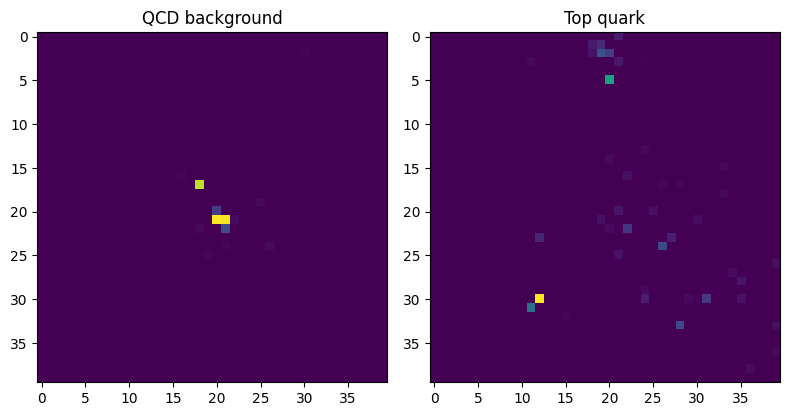

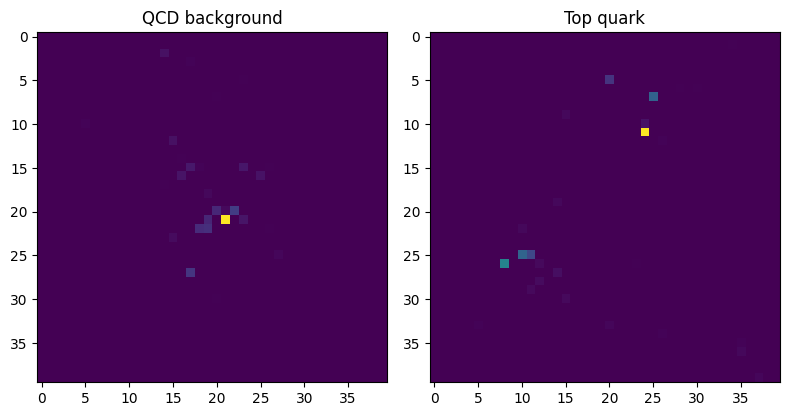

In [ ]:
for i in range(2):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("QCD background")
    plt.imshow(qcd_images[i])
    plt.subplot(1, 2, 2)
    plt.title("Top quark")
    plt.imshow(top_images[i])
    plt.tight_layout()
    plt.show()

Notice how the background events are much more clustered around the centre, while the top-quark jets have multiple "prongs". We can see this more clearly by averaging the pixel values across all events:

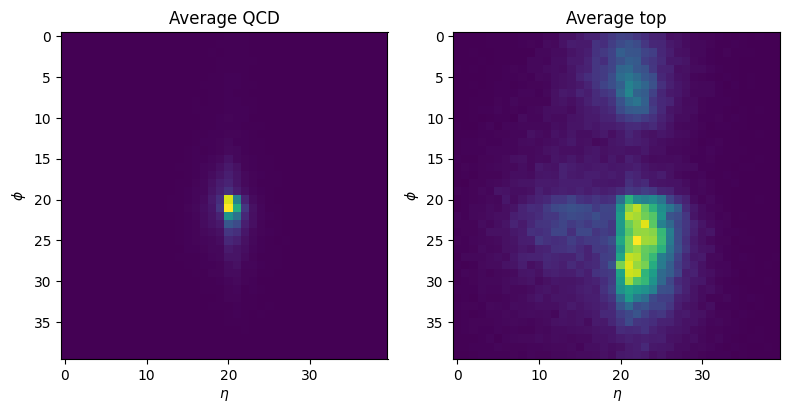

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.sum(qcd_images, axis=0))
plt.title("Average QCD")
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

plt.subplot(1, 2, 2)
plt.imshow(np.sum(top_images, axis=0))
plt.title("Average top")
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

plt.tight_layout()
plt.show()

Great, we now have a way to convert raw 4-vectors into jet images! For convenience, we've applied the above steps to the whole `top_tagging` dataset, so let's download it now from the [Hugging Face Hub](https://huggingface.co/datasets/dl4phys/top_tagging_images):

In [ ]:
images_ds = load_dataset("dl4phys/top_tagging_images")
images_ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1211000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 404000
    })
})

Here we now have three splits to work with, and we can access an individual image by indexing as follows:

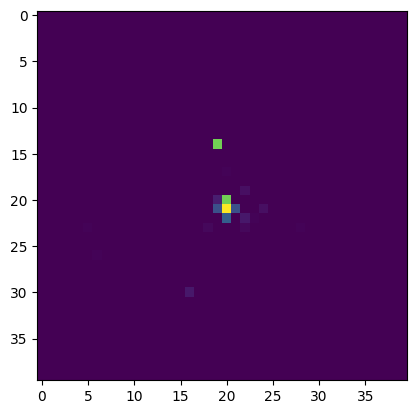

In [ ]:
img = images_ds["train"][0]["image"]
plt.imshow(img);

Okay, this looks like a jet image - let's now take a look at converting them to PyTorch tensors that are suitable for training a neural net!

## From images to tensors

Now that we have a dataset of images, the next thing we need to do is convert them to PyTorch tensors and wrap them in a `DataLoader`. One way to do this is via `torchvision`'s `ToTensor` class, which converts a PIL image into a tensor as follows:

In [ ]:
t = ToTensor()(img)
t.shape

torch.Size([1, 40, 40])

Here we can see that we now have a tensor of shape `(num_channels, height, width)`, where `num_channels` is 1 because we're dealing with black and white images, and `height` and `width` denote the number of pixels. To apply `ToTensor` to multiple images, we can use a list comprehension and `torch.cat()` to concatenate all the tensors as a single tensor:

In [ ]:
x = torch.cat([ToTensor()(img) for img in images_ds["train"][:10]["image"]])
x.shape

torch.Size([10, 40, 40])

Now this isn't quite what we want because CNNs in PyTorch expect rank-4 tensors with a shape `(minibatch, channels, height, width)`, where `channels` refers to the number of color channels (e.g. RGB) of the image. In our case, the images are black and white, so we just need to reshape the tensor to insert a new dimension in the second position:

In [ ]:
x = torch.cat([ToTensor()(img) for img in images_ds["train"][:10]["image"]])
x.unsqueeze_(dim=1)
x.shape

torch.Size([10, 1, 40, 40])

Great, we now have the image tensors in the right shape, so let write a simple `get_dataset()` helper function that applies this over a single training split:

In [ ]:
def get_dataset(dataset, num_examples=None):
    if num_examples is not None:
        dataset = dataset.shuffle(seed=42).select(range(num_examples))

    x = torch.cat([ToTensor()(img) for img in dataset["image"]]).unsqueeze(1)
    y = torch.cat([torch.tensor(l).unsqueeze(0) for l in dataset["label"]])

    return TensorDataset(x, y)

Here we've also collected the labels in a single tensor and returned a `TensorDataset` object that we can iterate over:

In [ ]:
# Lower the training size if Colab RAM explodes 💣
train_ds = get_dataset(images_ds["train"], num_examples=350_000)
valid_ds = get_dataset(images_ds["validation"], num_examples=50_000)

Now that we have the PyTorch datasets prepared, let's wrap them in dataloaders so we can generate minibatches during training:

In [ ]:
train_dl = DataLoader(train_ds, bs=128, shuffle=True)
valid_dl = DataLoader(valid_ds, bs=128)
dls = DataLoaders(train_dl, valid_dl)

## Fine-tuning a pretrained CNN

Now that we have prepared our data and created dataloaders, we can train a CNN! Instead of training a CNN from scratch, we'll use a _pretrained model_ that has been already been trained to classify over a million photos in the famous [ImageNet dataset](https://www.image-net.org/). These models are called "pretrained" because their weights have already been optimized by training on another dataset. The layers in a pretrained model are well suited for detecting edges, colour gradient and so on, which allows us to train a new model with much less labelled data, and much faster.

In practice, we replace the last layer of the pretrained model with a randomly initialized one that has the appropriate shape for the task at hand. For instance, ImageNet involves 1,000 different classes, so if we want to re-use the weights of a model trained on this dataset for a new set of classes, we'll need to resize the last layer. This last layer is often referred to as the _head_ of the network, with every layer before it belonging to the _body_.

This process of reusing the weights to solve a different task is called _transfer learning_, and now underpins much of the success that deep learning has achieved in computer vision, natural language processing, and audio. A cartoon of the process is shown below:

<center>
    <img alt="transfer" caption="Transfer learning" src="https://github.com/lewtun/dl4phys/blob/main/images/transfer-learning.png?raw=1" id="transfer-learning" width=800/>
</center>

Anyway, enough jargon - let's train a model! As we did in lecture 1, we'll use the high-level API of fastai, which provides factory methods for various domains. Instead of a `tabular_learner()` we'll use the `vision_learner()`, which is designed for computer vision tasks:

In [ ]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=[accuracy, RocAucBinary()],
    n_in=1,
    n_out=2,
    normalize=False,
    loss_func=F.cross_entropy,
)

Here we've provided the dataloaders and specified `resnet34` as the name of the pretrained model we wish to initialise with. ResNets are a popular type of CNN that we might cover in a future lesson, but for now it is enough to know that they are great for most computer vision tasks. Now, because we're using custom dataloaders instead of the factory methods provided by fastai, we need to specify that our model should run on a GPU instead of CPU (the default). We can do that by tapping into the model and selecting the desired device name with PyTorch's `to()` method:

In [ ]:
learn.model.to("cuda");

Now that our model is on the GPU, we can follow the same steps we've done in previous lectures. First we find a good learning rate:

SuggestedLRs(valley=0.0006918309954926372)

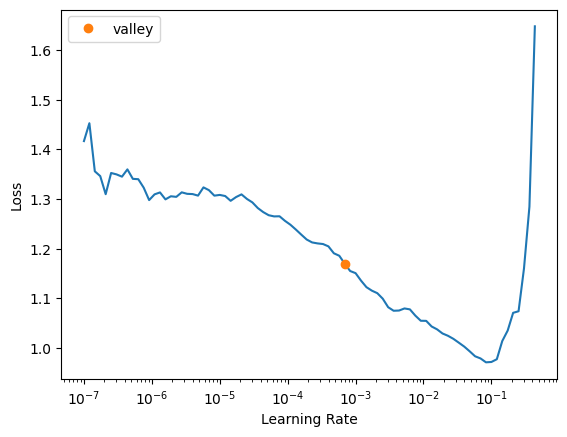

In [ ]:
learn.lr_find()

And finally we can train the model:

In [ ]:
learn.fine_tune(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.311838,0.283510,0.879120,0.949297,01:54


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.236097,0.237741,0.902600,0.964368,02:54
1,0.215431,0.216769,0.910620,0.970326,02:54
2,0.200479,0.211198,0.913180,0.971488,02:54


Note that this time we didn't call `fit()` or `fit_one_cycle()` as we've done in previous lectures. That's because we're starting with a pretrained model whose weights we "fine-tuned" to the new dataset of jet images. This process involves some tricks which is why it is called `fine_tune()`. Anyway, we've now got a model that scores pretty well on the validation set. Let's compute the same metrics we did in lecture 1, but now on the test set:

In [ ]:
test_ds = get_dataset(images_ds["test"], num_examples=50_000)
test_dl = learn.dls.test_dl(test_items=test_ds)
preds, targs = learn.get_preds(dl=test_dl)

In [ ]:
fpr, tpr, _ = roc_curve(y_true=targs, y_score=preds[:, 1])
acc_test = accuracy_score(targs, preds.argmax(dim=-1))
auc_test = auc(fpr, tpr)

In [ ]:
background_eff = interp1d(tpr, fpr)
background_eff_at_30 = background_eff(0.3)

In [ ]:
print(f"Accuracy: {acc_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print(
    f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}"
)

Accuracy: 0.9138
AUC: 0.9719
Backround rejection at signal efficiency 0.3: 381.738


Comparing our results against those in the top tagging review, shows that our CNN is getting quite competitive results with the state-of-the-art!

<center>
    <img alt="transfer" caption="Transfer learning" src="https://github.com/lewtun/dl4phys/blob/main/images/top-tagging-scores.png?raw=1" id="transfer-learning" width=800/>
</center>

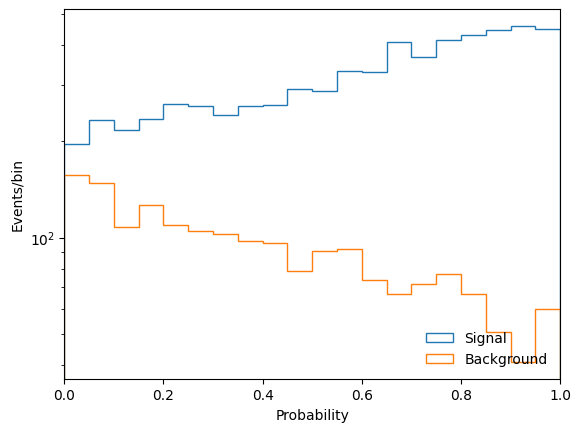

In [ ]:
signal_test = preds[:, 1][targs.flatten() == 1].numpy()
background_test = preds[:, 1][targs.flatten() == 0].numpy()

plt.hist(signal_test, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

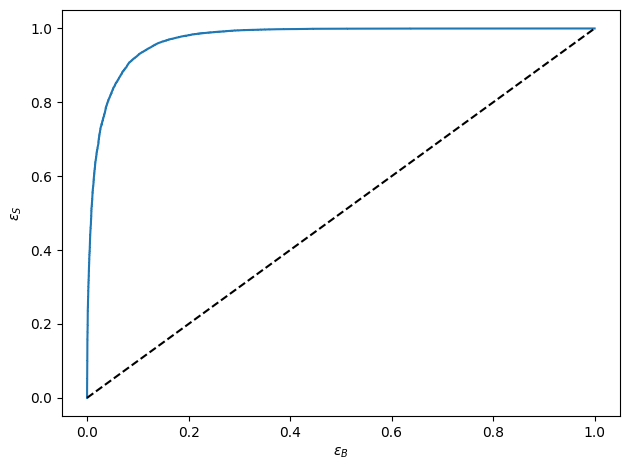

In [ ]:
# fpr = epsilon_B, tpr = epsilon_S
fpr, tpr, thresholds = roc_curve(y_true=targs, y_score=preds[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()